In [121]:
import mmh3
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from scipy.stats import chisquare
import warnings
warnings.filterwarnings('ignore')

In [122]:
def get_sorted_counts(data):
    unique, counts = np.unique(data, return_counts=True)
    counts[::-1].sort()
    return counts

In [123]:
def chisquare_test(counts, power=1.16, alpha=1):
    skip = int(0.005*len(counts))
    
    frequencies = np.array([alpha / np.power(i, power) for i in range(1, len(counts) + 1)])
    zipf_counts = frequencies
    
    counts, zipf_counts = counts[skip:], zipf_counts[skip:]

    chi = chisquare(counts, zipf_counts)
    return chi[1], counts, zipf_counts

In [124]:
    def parameter_estimation(sample):
        unique, counts = np.unique(sample, return_counts=True)
        counts = -np.sort(-counts)
        start = 10
        counts = counts[np.where(counts >= 5)]
        counts = counts[start:]
        m = len(counts)
        logf = np.log(counts)
        logn = np.log(np.arange(start=1, stop=m + 1, step=1) + start)
        s = (m * np.dot(logf, logn) / np.sum(logn) - np.sum(logf)) / (np.sum(logn) - m * np.dot(logn, logn) / np.sum(logn))
        alpha = np.exp((s * np.dot(logn, logn) + np.dot(logn, logf)) / np.sum(logn))
        return (s, alpha)

In [125]:
def hash_distributed_test(test, sample, distributed_sample, to_plot, paral_size=10):
    for el in sample:
        distributed_sample[mmh3.hash(str('qwerty' + el)) % paral_size].append(el)

    p_values = {}

    for ds in distributed_sample:
        data = distributed_sample[ds]

        counts = get_sorted_counts(data)
        power, alpha = parameter_estimation(data)
        p_values[ds], counts, zipf_counts = test(counts, power, alpha)

        to_plot[str(paral_size) + '.' + str(ds)] = counts, zipf_counts
    return p_values

In [126]:
def plot_partitions(ps, partitions):
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.4)
    for idx, (part, data) in enumerate(partitions.items()):
        rows = (1 + ps) * ps // 4
        plt.subplot(rows, 2, idx + 1)
        plt.scatter(*zip(*data[:4000]),s=1)
        plt.xlabel('size')
        plt.ylabel('p-value')
        plt.title('Partition: ' + part)
    plt.show()

In [127]:
def test_batch_size_on_war_and_peace(batch_size=100, text_size=10000):
    file = open('war_and_peace.txt', 'r')
    text = file.read().lower()
    words = re.sub('\W', ' ', text).split()[:text_size]

    to_plot = {}
    partitions = defaultdict(list)

    tests = {'chi': chisquare_test}
    
    max_paral_size = 4
    paral_sizes = range(1, max_paral_size + 1)
    
    for name in tests:
        for ps in paral_sizes:
            distributed_sample = defaultdict(list)
            for boundary in range(batch_size, text_size, batch_size):
                p_values = hash_distributed_test(tests[name], words[boundary - batch_size:boundary],
                                                 distributed_sample,
                                                 to_plot,
                                                 paral_size=ps)
                for i in range(ps):
                    if i in p_values:
                        partitions[str(ps) + '.' + str(i)].append((boundary, p_values[i]))

    plot_partitions(max_paral_size, partitions)

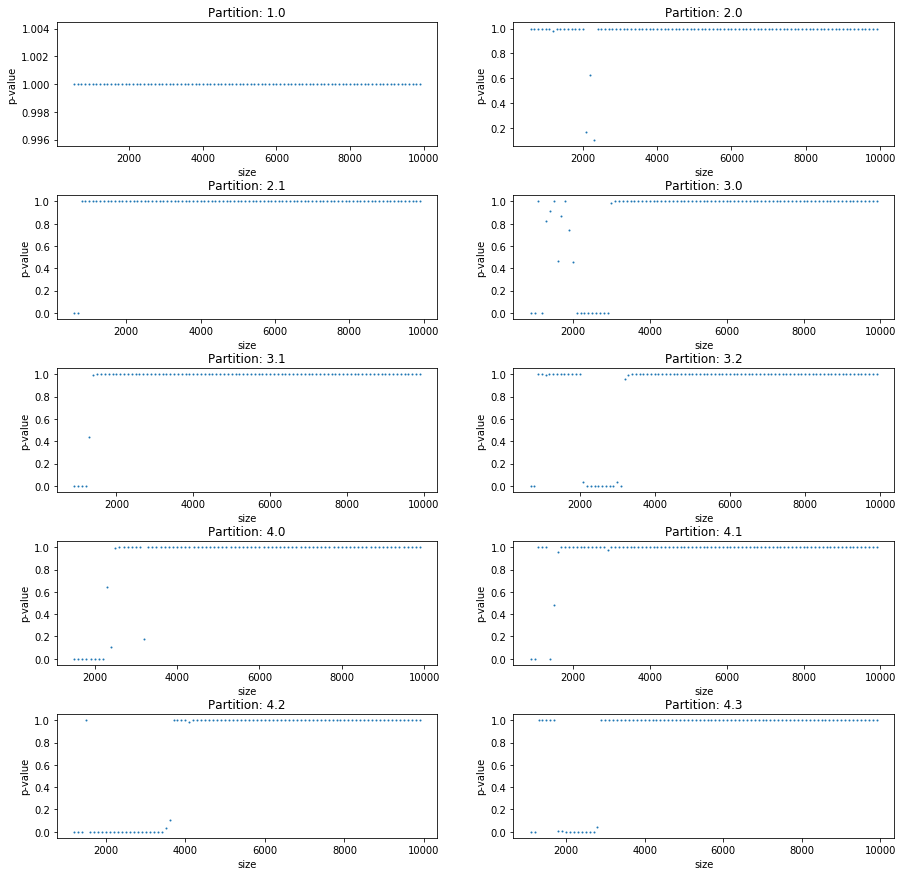

In [128]:
test_batch_size_on_war_and_peace(100)

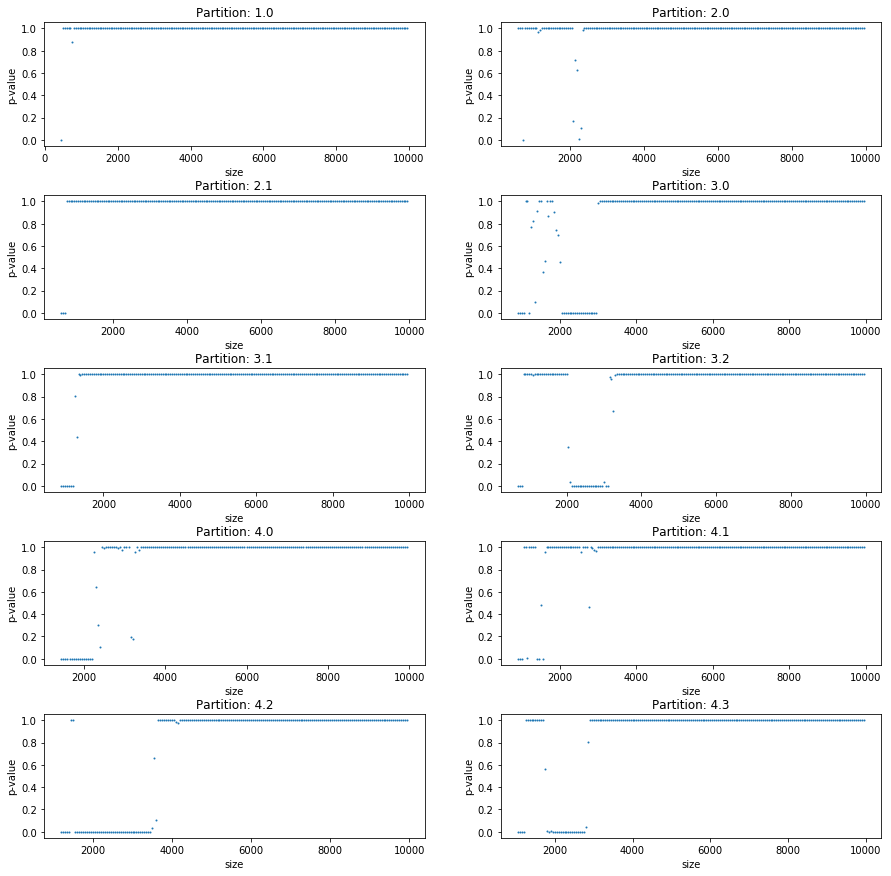

In [129]:
test_batch_size_on_war_and_peace(50)

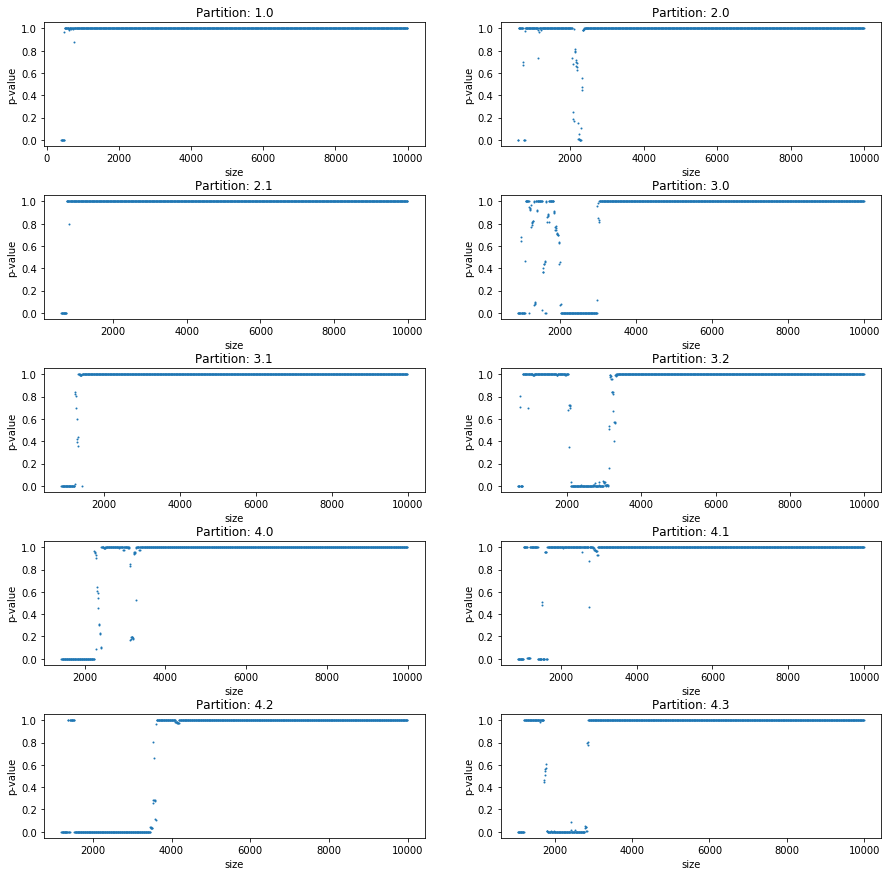

In [130]:
test_batch_size_on_war_and_peace(10)

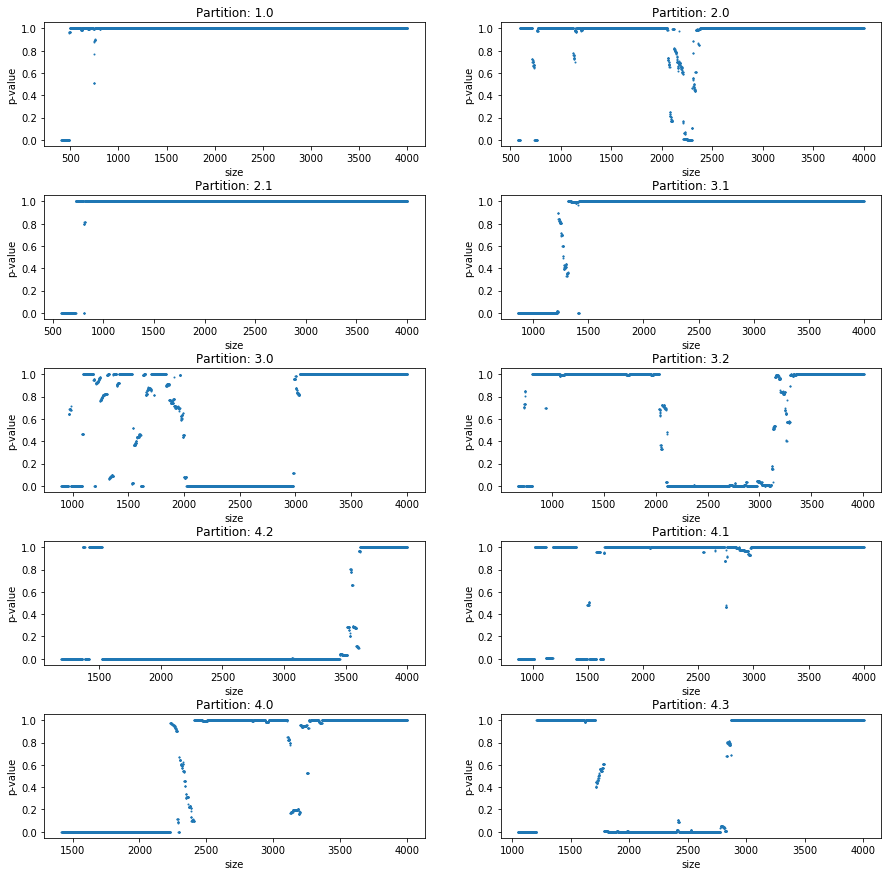

In [131]:
test_batch_size_on_war_and_peace(1)